In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.369838  0.726112 -0.273807  0.357546 -0.157038  0.124570 -0.656339   
  1   0.529478 -0.066502  0.405743  0.284445 -0.220981  1.019994  0.613044   
  2   0.341093 -0.356510  0.041317  0.083865 -0.810518  0.584715  0.090901   
  3   0.092370  0.711250  0.448498  0.880327 -0.091339 -0.760096  0.381375   
  4  -0.117815 -0.626710 -0.598883  0.758965  1.333746  0.886375  0.342827   
  5   1.279765 -0.033409 -0.126974 -0.394063  0.601012  0.554610 -0.234871   
  6   0.451359  0.209952 -0.152786 -0.549515 -0.639737  1.070458  0.474594   
  7   0.159774  0.406748  0.257210  0.136793 -1.193745  0.025472  0.245373   
  8  -0.245215  0.011092 -0.412583  0.504606  0.632039  1.357250  0.185361   
  9  -0.083009 -0.764098 -0.349908  0.042148  0.040704  1.327113 -0.407458   
  10  0.171773  0.381088  0.551093 -0.213090 -1.014310  0.207537  0.399225   
  11 -0.103145  0.099672 -0.297418  0.951671 -0.543243  0.505118 -0.797305   
  12 -0.110335  0.190722  1.543216  1.594690  0.525954  1.136172  0.039125   
  13  0.564461  0.202268 -0.869408  0.565477 -0.913645  0.766394  0.192808   
  14 -1.128831 -0.559931 -0.775387 -0.680150 -1.086498 -0.234678 -0.007811   
  15  0.343413  0.192158  0.384810  1.338959 -0.150426  1.581709  1.074291   
  16 -0.065294 -1.288544 -1.372225  0.118578 -0.022355  0.672102 -1.419346   
  17 -0.312295  0.515405 -0.225642  0.499989  0.229539  0.509195  0.180457   
  18 -0.631321 -0.494703  1.156730  0.283089  0.207184  0.280867  0.039292   
  19 -0.009260 -0.014421 -0.417886  1.294343 -0.405634  0.347977  0.019216   
  20  0.149308 -0.605709 -0.134741  0.986301  1.215657  0.641764 -0.092715   
  21  0.108107 -0.484603 -0.708512  0.802292  0.074708 -0.251527 -1.054609   
  22 -0.195358 -0.181492  0.415483  0.357942  0.133611  0.157747  0.460390   
  23  0.646087  1.102878  0.713634  0.197626 -0.383459  0.532410 -0.343331   
  24  0.230171  0.374733 -0.445903 -0.314598  0.219082  1.110946  0.015476   
1 0   0.558411  0.939057  0.286505 -0.091951 -0.718392  0.380966  0.102998   
  1  -0.021304 -0.100036 -0.314963 -0.298669 -1.083063 -0.446481 -1.033098   
  2  -0.136474  0.414152  0.265174 -0.655273 -1.205491 -0.826127 -0.166049   
  3   0.681405  0.987722  0.391321  0.987141 -0.408480 -0.102733  0.231198   
  4   0.192360  0.632447 -0.335661 -0.400392 -0.204761 -0.802906 -0.373256   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.188588 -0.794902 -1.291480  ... -0.035285 -0.641395 -0.592735   
  1   0.343658 -0.977704  0.137681  ... -0.925004 -0.596267 -0.071528   
  2  -0.288582  0.637723 -0.762204  ... -0.316494 -1.351405 -0.116665   
  3   0.409992 -0.306522 -0.380911  ...  0.010920 -0.816082 -1.387424   
  4  -0.192657 -0.462273 -0.074155  ...  0.544216 -0.016137  0.561553   
  5  -0.671158 -1.189753 -1.255000  ...  0.028668 -1.552142 -1.244686   
  6  -0.219824 -0.868832 -1.674396  ... -0.863417  0.011609  0.723845   
  7   0.913364 -1.013506 -1.043266  ... -0.972805 -0.530176  0.182843   
  8  -0.608307 -0.781725 -0.719094  ... -0.079404 -1.345379 -0.418795   
  9   0.184574 -0.502668 -1.280592  ... -0.064347  0.230894  0.384574   
  10 -0.450178 -0.760914 -1.394598  ...  0.374644 -0.080958  0.231147   
  11 -1.189819 -1.265680 -0.914885  ...  0.129054 -0.564278 -0.020638   
  12  0.704500 -0.231562  0.428427  ... -0.928585  0.197299 -0.146978   
  13  0.035147 -0.510732 -0.876154  ... -0.308445  0.063887 -0.521872   
  14 -0.338052 -0.401693 -0.571994  ...  0.919856 -0.337350  0.095566   
  15  0.137792 -0.425351 -0.522758  ...  0.314289 -0.616071  0.567324   
  16 -0.667209  0.225747 -0.358751  ... -0.786572 -0.681336  1.066402   
  17 -0.517395 -0.579426 -0.510847  ...  0.000588  0.135574  0.196503   
  18 -0.683417 -1.034582 -0.414905  ... -0.604167 -1.190961 -0.323027   
  19 -0.491690 -0.676954 -0.514180  ... -0.614279  0.021201 -0.199658   
  20  0.713043  0.142893  0.858454  ...  0.519943 -0.095357 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
D  0.976787  0.046493  21.009304  5.391939e-98  0.885662  1.067912


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



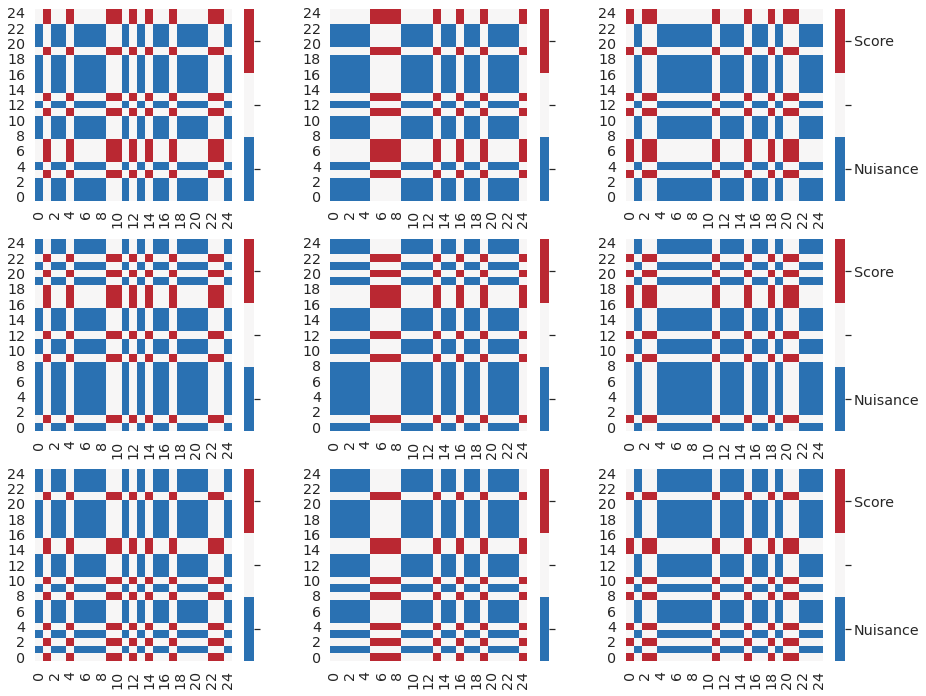

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



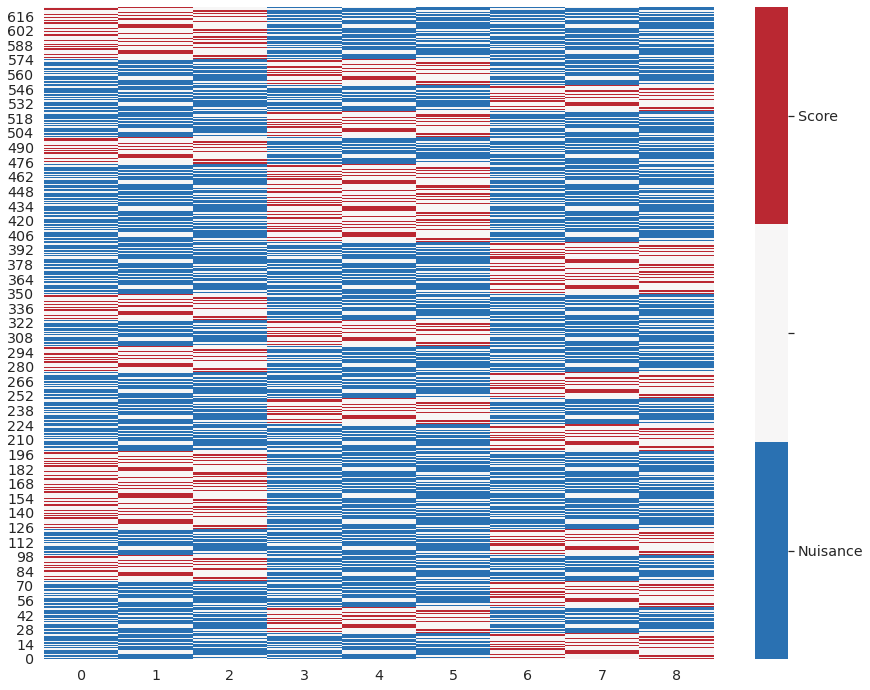

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])